# **PREPROCESAMIENTO DE IMÁGENES**

In [ ]:
import os
import pandas as pd
import numpy as np
from pathlib import Path
from datetime import datetime
from tqdm import tqdm

  # noqa


import nibabel as nib
import numpy as np
import pandas as pd
from skimage.transform import resize
from pathlib import Path
import os

# [Config] Librerías
import os, torch
from torch.utils.data import Dataset
from sklearn.model_selection import GroupShuffleSplit
import numpy as np
import pandas as pd
from pathlib import Path
from statsmodels.stats.proportion import proportions_ztest
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.model_selection import StratifiedShuffleSplit
from torch.utils.data import Dataset, DataLoader
import torch


In [23]:
# [Config] Rutas
# Ajusta estas rutas según tu estructura
BASE_IMAGES_DIR = Path(r"C:\Users\Hp\MACHINE\MRI\Datos\IMAGES")   
NOTEBOOKS_DIR = Path(r"C:\Users\Hp\MACHINE\MRI\notebooks")
OUT_DIR = Path(r"C:\Users\Hp\MACHINE\MRI\datos\procesadas")      
OUT_DIR.mkdir(parents=True, exist_ok=True)
df = pd.read_csv("./Data/ADNI_Images.csv")


## Rutas a archivos y estandarización de variables

_____________
* 1. Verificar y normalizar rutas a archivos .nii

In [ ]:
# Normalizar rutas a los archivos nii
def normalize_path(p):
    # Convierte rutas relativas 
    p = str(p)
    return Path(p.replace("/", os.sep)).resolve()
df['ruta_abs'] = df['ruta'].apply(lambda p: normalize_path(p) if pd.notnull(p) else p)

________
* 2. Crear identificadores y nombres de salida

In [ ]:
# Normalizamos campos clave
df['sujeto_id'] = df['sujeto_id'].astype(str)
df['VISCODE'] = df['VISCODE'].astype(str)

def parse_date(x):
    if pd.isnull(x): 
        return pd.NaT
    if isinstance(x, (datetime, pd.Timestamp)):
        return pd.to_datetime(x)
    # probar distintos formatos comunes
    for fmt in ("%Y-%m-%d", "%Y/%m/%d", "%d-%m-%Y", "%Y-%m-%d %H:%M:%S", "%Y-%m-%dT%H:%M:%S"):
        try:
            return pd.to_datetime(x, format=fmt)
        except Exception:
            pass
    return pd.to_datetime(x, errors='coerce')

df['Fecha'] = df['EXAMDATE'].apply(parse_date)

In [ ]:
# Crear id_visita
df['id_visita'] = df['sujeto_id'] + "_" + df['VISCODE']
def safe_fname(s):
    # quita espacios, reemplaza / : etc
    return "".join(c if c.isalnum() or c in ("-", "_") else "_" for c in s)

def make_output_fname(row):
    subj = row['sujeto_id']
    vis = row['VISCODE']
    examdate = row['Fecha']
    exam_str = examdate.strftime("%Y%m%d") if pd.notnull(examdate) else "noDate"
    arch = Path(row['archivo']).stem
    fname = f"{subj}_{exam_str}_{vis}_{arch}.npy"
    return safe_fname(fname)

# Crear rutas de salida
df['fname_out'] = df.apply(make_output_fname, axis=1)
df['ruta_npy'] = df['fname_out'].apply(lambda s: OUT_DIR / s)


____________
* 3. Construir etiquetas binarias

In [ ]:
# Definimos mapa VISCODE -> meses
viscode_to_month = {'bl':0, 'm06':6, 'm12':12, 'm18':18, 'm24':24, 'm30':30, 'm36':36}
df['vis_month'] = df['VISCODE'].map(viscode_to_month)

In [28]:
def dx_is_dementia(dx):
    if pd.isnull(dx):
        return np.nan
    s = str(dx).lower()
    if 'dementia' in s:
        return 1
    if 'mci' in s:
        return 0
    return np.nan
df['is_dementia'] = df['DX'].apply(dx_is_dementia)

In [29]:
# Construir label por sujeto:
# Regla: si sujeto presenta transición de non-dementia -> dementia en algún vis <=36 meses -> label 1.
# Implementación simplificada:
labels = []
subjects = df['sujeto_id'].unique()
for subj in tqdm(subjects, desc="Calculando labels por sujeto"):
    subdf = df[df['sujeto_id']==subj].copy()
    # orden por vis_month (si NaN, orden por Fecha)
    if subdf['vis_month'].notna().any():
        subdf = subdf.sort_values(by=['vis_month','Fecha'])
    else:
        subdf = subdf.sort_values(by='')
    # buscamos primer visita con is_dementia==1 y su mes
    # y primer visita con is_dementia==0 (baseline non-dementia)
    baseline_non_d = subdf[subdf['is_dementia']==0]
    first_non_d = None
    if not baseline_non_d.empty:
        # preferir VISCODE 'bl' si existe
        if (baseline_non_d['VISCODE'].str.lower()=='bl').any():
            first_non_d = baseline_non_d[baseline_non_d['VISCODE'].str.lower()=='bl'].iloc[0]
        else:
            first_non_d = baseline_non_d.iloc[0]
    # buscar conversion
    converted = False
    conversion_info = None
    # consideramos cualquier visita con is_dementia==1 y vis_month <= 36
    dem_vis = subdf[subdf['is_dementia']==1]
    if not dem_vis.empty:
        # si hay baseline non-dementia, la conversión debe ocurrir tras baseline
        if first_non_d is not None:
            # buscar dem_vis cuya month >= baseline month y <=36
            base_month = first_non_d.get('vis_month', 0) if pd.notnull(first_non_d.get('vis_month', np.nan)) else 0
            # candidate dem_vis posteriores
            for _, r in dem_vis.iterrows():
                month = r.get('vis_month', np.nan)
                if pd.isna(month):
                    # si no hay month, intentar por fecha diff
                    if pd.notnull(first_non_d['Fecha']) and pd.notnull(r['Fecha']):
                        diff_months = (r['Fecha'].year - first_non_d['Fecha'].year)*12 + (r['Fecha'].month - first_non_d['Fecha'].month)
                        month = diff_months
                # now check range
                if pd.notnull(month) and (month >= base_month) and (month <= 36):
                    converted = True
                    conversion_info = (r['VISCODE'], month, r['Fecha'])
                    break
        else:
            # No baseline non-dementia conocido: fallback -> if any dem_vis within <=36 -> label may be ambiguous:
            # we'll mark converted if there's any dem_vis with vis_month<=36
            for _, r in dem_vis.iterrows():
                month = r.get('vis_month', np.nan)
                if pd.notnull(month) and month <= 36:
                    converted = True
                    conversion_info = (r['VISCODE'], month, r['Fecha'])
                    break
    # Save label for all rows of this subject (we attach label at image-row level later)
    labels.append({'sujeto_id': subj, 'label_progresion': int(converted), 'conversion_info': conversion_info})

labels_df = pd.DataFrame(labels)
print("Labels por sujeto (ejemplo):")
display(labels_df.head(10))

Calculando labels por sujeto:   0%|          | 0/51 [00:00<?, ?it/s]

Calculando labels por sujeto: 100%|██████████| 51/51 [00:00<00:00, 199.03it/s]

Labels por sujeto (ejemplo):


,sujeto_id,label_progresion,conversion_info
0,007_S_0101,1,"(m24, 24, 2007-12-12 00:00:00)"
1,007_S_0128,1,"(m18, 18, 2007-08-20 00:00:00)"
2,007_S_0249,1,"(m12, 12, 2007-04-03 00:00:00)"
3,013_S_0240,1,"(m18, 18, 2007-10-31 00:00:00)"
4,014_S_0169,0,None
5,018_S_0057,1,"(m18, 18, 2007-08-21 00:00:00)"
6,018_S_0080,0,None
7,018_S_0087,0,None
8,018_S_0142,0,None
9,018_S_0155,0,None


In [ ]:
# Resumen de labels
df = df.merge(labels_df[['sujeto_id','label_progresion']], on='sujeto_id', how='left')

print("Resumen labels (por sujeto):")
display(labels_df['label_progresion'].value_counts(dropna=False).to_frame())

Resumen labels (por sujeto):


,count
label_progresion,
0,29
1,22


In [31]:
# Variables y labels 
columnas_id = ['sujeto_id', 'id_visita', 'Fecha', 'VISCODE', 'vis_month', 'is_dementia', 'label_progresion', 'ruta_npy']

## Valores nulos e imputación

____________
* 1. Exploración de valores nulos

In [32]:
# Análisis de variables nulas 
cognitivas = [
    "CDRSB", #"Suma de cajas del Clinical Dementia Rating (CDR); mide la severidad de la demencia.",
    "MMSE", #"Mini-Mental State Examination; evaluación global del estado cognitivo (máx. 30 puntos).",
    "ADAS13", #"Alzheimer’s Disease Assessment Scale – 13 ítems; mide deterioro cognitivo en Alzheimer.",
    "FAQ", #"Functional Activities Questionnaire; evalúa la capacidad funcional en actividades diarias.",
    "RAVLT_immediate", # "Puntuación inmediata en la prueba verbal de aprendizaje (Rey Auditory Verbal Learning Test).",
    "RAVLT_learning", # "Puntuación de aprendizaje acumulado en RAVLT; mide retención verbal.",
    "RAVLT_forgetting", # "Índice de olvido en RAVLT; diferencia entre aprendizaje y recuerdo tardío.",
    "DIGITSCOR", #"Digit Span Score; mide memoria de trabajo y atención mediante secuencias numéricas.",
    "TRABSCOR", # "Trail Making Test B Score; evalúa función ejecutiva y flexibilidad cognitiva.",
]
volumen = [
    "Ventricles", # "Volumen de los ventrículos cerebrales; puede indicar atrofia cerebral.",
    "Hippocampus", # "Volumen del hipocampo; clave en memoria y afectado en Alzheimer.",
    "WholeBrain", # "Volumen total del cerebro; útil para evaluar atrofia global.",
    "Entorhinal", # "Volumen de la corteza entorrinal; región afectada tempranamente en Alzheimer.",
    "Fusiform", #"Volumen del giro fusiforme; relacionado con reconocimiento visual.",
    "MidTemp", # "Volumen del lóbulo temporal medio; implicado en memoria y procesamiento auditivo.",
    "ICV", #"Volumen intracraneal total; usado para normalizar medidas volumétricas."
]

In [33]:
def resumen_nulos(df, variables, nombre_grupo):
    # Asegurar que las variables existan en el DataFrame
    variables = [v for v in variables if v in df.columns]
    print('-'*50)
    print(f"Variables consideradas ({nombre_grupo}): \n{variables}")

    # Conteo y proporción de nulos
    nulos_totales = df[variables].isna().sum()
    proporcion_nulos = df[variables].isna().mean() * 100

    # Mostrar resumen
    resumen = pd.DataFrame({
        "nulos": nulos_totales,
        "porcentaje": proporcion_nulos.round(2)
    }).sort_values("porcentaje", ascending=False)

    print("\nResumen de nulos por variable:")
    print(resumen)

    # Filas con al menos un nulo en ese grupo
    df[f"nulos_{nombre_grupo}"] = df[variables].isna().any(axis=1)
    total_filas_nulas = df[f"nulos_{nombre_grupo}"].sum()
    porcentaje_filas_nulas = df[f"nulos_{nombre_grupo}"].mean() * 100

    print(f"\nFilas con al menos un nulo en {nombre_grupo}: {total_filas_nulas}")
    print(f"Proporción total: {porcentaje_filas_nulas:.2f}%")

print('-'*50)
print('Valores nulos')
resumen_nulos(df, cognitivas, "cognitivas")
resumen_nulos(df, volumen, "volumen")

--------------------------------------------------
Valores nulos
--------------------------------------------------
Variables consideradas (cognitivas): 
['CDRSB', 'MMSE', 'ADAS13', 'FAQ', 'RAVLT_immediate', 'RAVLT_learning', 'RAVLT_forgetting', 'DIGITSCOR', 'TRABSCOR']

Resumen de nulos por variable:
                  nulos  porcentaje
FAQ                  31       11.11
TRABSCOR             31       11.11
CDRSB                30       10.75
RAVLT_forgetting     30       10.75
ADAS13               29       10.39
RAVLT_immediate      29       10.39
RAVLT_learning       29       10.39
DIGITSCOR            29       10.39
MMSE                 28       10.04

Filas con al menos un nulo en cognitivas: 38
Proporción total: 13.62%
--------------------------------------------------
Variables consideradas (volumen): 
['Ventricles', 'Hippocampus', 'WholeBrain', 'Entorhinal', 'Fusiform', 'MidTemp', 'ICV']

Resumen de nulos por variable:
             nulos  porcentaje
Hippocampus     67       24.0

In [34]:
def imputar_y_normalizar(df, variables, nombre_grupo, out_dir=None):
   
    print('-'*50)
    # Filtrar solo variables numéricas válidas
    variables_num = [v for v in variables if v in df.columns and df[v].dtype.kind in "iufc"]
    print(f"Variables numéricas para imputación ({nombre_grupo}):\n{variables_num}")

    # Subset de datos
    datos = df[variables_num].copy()

    # Imputación multivariada
    # Modelo bayesiano iterativo para predecir valores faltantes en función de las demás variables.
    imputer = IterativeImputer(random_state=42, max_iter=20, sample_posterior=True)
    datos_imputados = imputer.fit_transform(datos)

    # Convertir a DataFrame imputado
    df_imputado = pd.DataFrame(datos_imputados, columns=variables_num, index=df.index)

    # Reemplazar en el DataFrame original
    for v in variables_num:
        df[v] = df_imputado[v]

    print("✅ Imputación completada.")

    # Normalización z-score
    scaler = StandardScaler()
    df_std = pd.DataFrame(
        scaler.fit_transform(df[variables_num]),
        columns=[v + "_std" for v in variables_num],
        index=df.index
    )

    # Concatenar al DataFrame original
    df = pd.concat([df, df_std], axis=1)

    return df

print('Imputación')
df = imputar_y_normalizar(df, cognitivas, "cognitivas", OUT_DIR)
df = imputar_y_normalizar(df, volumen, "volumen", OUT_DIR)

Imputación
--------------------------------------------------
Variables numéricas para imputación (cognitivas):
['CDRSB', 'MMSE', 'ADAS13', 'FAQ', 'RAVLT_immediate', 'RAVLT_learning', 'RAVLT_forgetting', 'DIGITSCOR', 'TRABSCOR']
✅ Imputación completada.
--------------------------------------------------
Variables numéricas para imputación (volumen):
['Ventricles', 'Hippocampus', 'WholeBrain', 'Entorhinal', 'Fusiform', 'MidTemp', 'ICV']
✅ Imputación completada.


In [35]:
# Variables categóricas
generos = {'Male':1, 'Female':0}
df['Sexo'] = df['PTGENDER'].map(generos)
df['Sexo'].unique()

df['Education'] = df['PTEDUCAT']

In [36]:
# DX con valores nulos
print("-" * 30)
print("📁 DX con valores nulos:")
print(f"Registros con DX nulos: {df['DX'].isna().sum()}")
porcentaje_nulo = df["DX"].isna().mean() * 100
print(f"{porcentaje_nulo:.2f}% de los registros no tienen DX asignado.")
df_dx_nulo = df[df["DX"].isna()]
print(f"Diagnosticos nulos en las vistas: {df_dx_nulo['VISCODE'].unique()}")

------------------------------
📁 DX con valores nulos:
Registros con DX nulos: 28
10.04% de los registros no tienen DX asignado.
Diagnosticos nulos en las vistas: ['m30']


In [37]:
columnas_dem = ['AGE', 'Sexo', 'Education']
columnas_std = [col for col in df.columns if col.endswith("_std")]

## Estandarización de las imágenes

In [38]:
# === Plantilla base (más frecuente) ===
TARGET_SHAPE = (160, 192, 192)
TARGET_VOXEL = (1.2, 0.9375, 0.9375)

In [ ]:
# === Funciones auxiliares ===

def normalize_intensity(data):
    """Normaliza intensidades tipo Z-score"""
    mean = np.mean(data)
    std = np.std(data)
    if std == 0:
        return np.zeros_like(data)
    return (data - mean) / std


def resize_image(data, target_shape):
    """Redimensiona al shape más frecuente"""
    return resize(data, target_shape, mode="constant", preserve_range=True)


def process_image(row):
    """
    Lee la imagen NIfTI, normaliza y guarda en formato .npy
    usando la ruta y nombre definidos en df['ruta_npy'].
    """
    nifti_path = Path(row["ruta_abs"])
    npy_path = Path(row["ruta_npy"])
    
    try:
        img = nib.load(nifti_path)
        data = img.get_fdata()

        # --- Resize si no coincide con el target ---
        if data.shape != TARGET_SHAPE:
            data = resize_image(data, TARGET_SHAPE)

        # --- Normalización de intensidades ---
        data = normalize_intensity(data)

        # --- Metadatos después del procesamiento ---
        shape_proc = data.shape
        mean_proc = float(np.mean(data))
        std_proc = float(np.std(data))
        

        # --- Guardar como .npy ---
        np.save(npy_path, data)

        return {
            "sujeto_id": row["sujeto_id"],
            "VISCODE": row["VISCODE"],
            "DX": row["DX"],
            "ruta_npy": str(npy_path),
            "fecha": row['Fecha'],

            "shape": shape_proc,
            "mean_intensity": mean_proc,
            "std_intensity": std_proc,

            "estado": "OK"
        }

    except Exception as e:
        print(f"❌ Error con {nifti_path.name}: {e}")
        return {
            "sujeto_id": row["sujeto_id"],
            "VISCODE": row["VISCODE"],
            "DX": row["DX"],
            "ruta_npy": str(npy_path),
            "procesado": False,
            "error": str(e)
        }

# === Aplicar a todas las filas ===

results = []
for _, row in df.iterrows():
    res = process_image(row)
    results.append(res)

df_npy = pd.DataFrame(results)

# === Guardar log final ===
df_npy.to_csv(OUT_DIR / "registro_imagenes_procesadas.csv", index=False)
print(f"✅ Procesamiento completo. Guardado en {OUT_DIR}")

## Crear archivos de atributos

In [40]:
atributos = pd.concat([df[columnas_id], df[columnas_dem], df[columnas_std]], axis=1)
atributos.columns

Index(['sujeto_id', 'id_visita', 'Fecha', 'VISCODE', 'vis_month',
       'is_dementia', 'label_progresion', 'ruta_npy', 'AGE', 'Sexo',
       'Education', 'CDRSB_std', 'MMSE_std', 'ADAS13_std', 'FAQ_std',
       'RAVLT_immediate_std', 'RAVLT_learning_std', 'RAVLT_forgetting_std',
       'DIGITSCOR_std', 'TRABSCOR_std', 'Ventricles_std', 'Hippocampus_std',
       'WholeBrain_std', 'Entorhinal_std', 'Fusiform_std', 'MidTemp_std',
       'ICV_std'],
      dtype='object')

In [41]:
atributos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 279 entries, 0 to 278
Data columns (total 27 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   sujeto_id             279 non-null    object        
 1   id_visita             279 non-null    object        
 2   Fecha                 279 non-null    datetime64[ns]
 3   VISCODE               279 non-null    object        
 4   vis_month             279 non-null    int64         
 5   is_dementia           251 non-null    float64       
 6   label_progresion      279 non-null    int64         
 7   ruta_npy              279 non-null    object        
 8   AGE                   279 non-null    float64       
 9   Sexo                  279 non-null    int64         
 10  Education             279 non-null    int64         
 11  CDRSB_std             279 non-null    float64       
 12  MMSE_std              279 non-null    float64       
 13  ADAS13_std          

In [42]:
FINAL_PATH = Path(r"C:\Users\Hp\MACHINE\MRI\notebooks\Data\atributos.csv")
atributos.to_csv(FINAL_PATH, index=False)
print(f"✅ Dataset final guardado en {FINAL_PATH}")

✅ Dataset final guardado en C:\Users\Hp\MACHINE\MRI\notebooks\Data\atributos.csv


## Preprocesamiento

In [43]:
# [Rutas]
OUT_DIR = Path(r"C:\Users\Hp\MACHINE\MRI\datos\procesadas")
df = pd.read_csv(r"C:\Users\Hp\MACHINE\MRI\notebooks\Data\atributos.csv")

In [44]:
# [] Valores nulos columnas principales
print("\nNulos por columna principal:")
print(df[["is_dementia", "label_progresion"]].isna().sum().to_frame())


Nulos por columna principal:
                   0
is_dementia       28
label_progresion   0


Los valores nulos están asociados a la visita del mes 30 de x sujetos (ver EDA). Estos valores no serán imputados para los primeros 3 modelos a probar.


 Distribución de la variable objetivo:
                  proportion
label_progresion            
0                      54.84
1                      45.16

Prueba Z-test: Z = -2.29, p-value = 0.0223


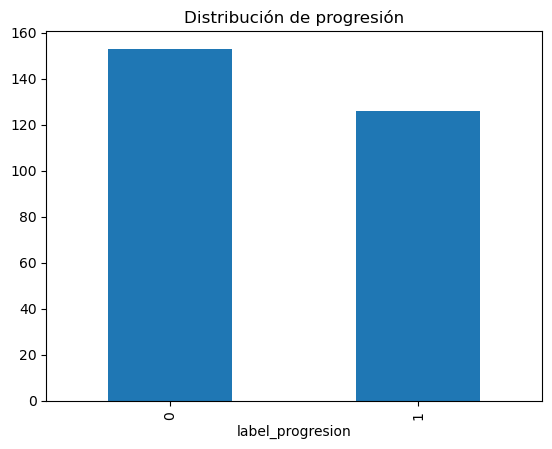

In [ ]:
# [] Balance de clases
print("\n Distribución de la variable objetivo:")
print(df["label_progresion"].value_counts(normalize=True).mul(100).round(2).to_frame())
df["label_progresion"].value_counts().plot(kind="bar", title="Distribución de progresión")

# [Test] Z-test para comparar proporciones
counts = [df["label_progresion"].value_counts()[1],
          df["label_progresion"].value_counts()[0]]
nobs = [sum(counts), sum(counts)]
stat, pval = proportions_ztest(counts, nobs)
print(f"\nPrueba Z-test: Z = {stat:.2f}, p-value = {pval:.4f}")


Las clases de la variable objetivo están significativamente desbalanceadas. Se aplicará en cada modelo ponderación de clases, para no realizar replicación de imágenes que cambien la distribución real. La clase mayoritaria es que no hubo progresión de la enfermedad.